In [17]:
import pandas as pd
import pickle
from scipy.stats import poisson
from string import ascii_uppercase as alphabet
import numpy as np 
from scipy.spatial.distance import euclidean
from math import sqrt
%matplotlib inline
%config InlineBackend.figure_format = 'pdf'

In [2]:
dict_table = pickle.load(open('dict_table','rb'))
df_historical_data = pd.read_csv('clean_fifa_euro_matches.csv')
df_fixture = pd.read_csv('clean_fifa_euro_fixture.csv')

In [3]:
df_historical1 = df_historical_data[df_historical_data.Year == 2020]

In [4]:
df_home = df_historical1[['HomeTeam', 'HomeGoals', 'AwayGoals']]
df_away = df_historical1[['AwayTeam', 'HomeGoals', 'AwayGoals']]

df_home = df_home.rename(columns={'HomeTeam':'Team', 'HomeGoals': 'GoalsScored', 'AwayGoals': 'GoalsConceded'})
df_away = df_away.rename(columns={'AwayTeam':'Team', 'HomeGoals': 'GoalsConceded', 'AwayGoals': 'GoalsScored'})

df_team_strength = pd.concat([df_home, df_away], ignore_index=True).groupby(['Team']).mean()

# Poisson distribution: Assumptions
## Goal: Event that might happen in the 90 minutes of a football match  
- The number of events can be counted  
- The occurrence of events are independent  
- The rate at which events occur is constant  
- Two events cannot occur at exactly the same instant of time  

![poisson](poisson.png)


## Poisson distribution legend

- lambda : Excepted number of events per time interval.
- lambda exponentielle : Median of goals in 90 minutes (Team A and B).
- x : Number of goals in a match that could be scored by team A or team B.

In [5]:
#model using poisson probabilities 
def predict_points(home, away):
    if home in df_team_strength.index and away in df_team_strength.index:
        # goals_scored * goals_conceded
        lamb_home = df_team_strength.at[home,'GoalsScored'] * df_team_strength.at[away,'GoalsConceded']
        lamb_away = df_team_strength.at[away,'GoalsScored'] * df_team_strength.at[home,'GoalsConceded']
        prob_home, prob_away, prob_draw = 0, 0, 0
        for x in range(0,11): #number of goals home team
            for y in range(0, 11): #number of goals away team
                p = poisson.pmf(x, lamb_home) * poisson.pmf(y, lamb_away)
                if x == y:
                    prob_draw += p
                elif x > y:
                    prob_home += p
                else:
                    prob_away += p
        
        points_home = 3 * prob_home + prob_draw
        points_away = 3 * prob_away + prob_draw
        return (points_home, points_away)
    else:
        return (0, 0)

In [6]:
df_historical1 = df_historical1.copy()
df_historical1['BestTeam'] = df_historical1.apply(lambda row: row['HomeTeam'] if row['HomeGoals'] > row['AwayGoals'] else (row['AwayTeam'] if row['HomeGoals'] < row['AwayGoals'] else 'nul'), axis=1)


# Ajouter les équipes préférées dans une liste
best_team = df_historical1['BestTeam'].tolist()

In [7]:
df_filtered = df_historical1[df_historical1['BestTeam'] != 'nul']
df_match = df_historical1[df_historical1['BestTeam'] == 'nul']

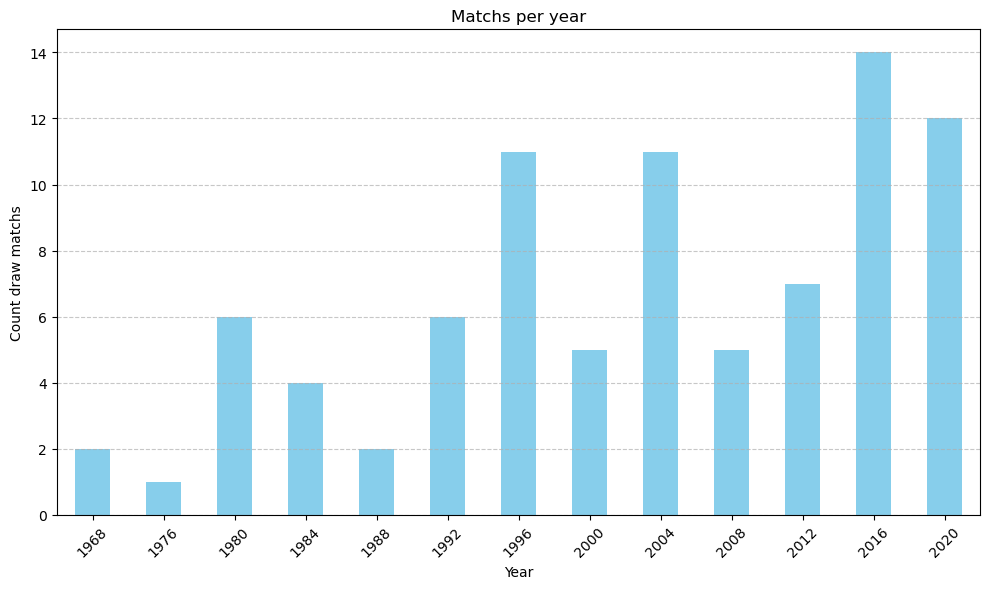

In [8]:
import matplotlib.pyplot as plt
matches_nuls = df_historical_data[df_historical_data['HomeGoals'] == df_historical_data['AwayGoals']]


nombre_matchs_nuls_par_annee = matches_nuls.groupby('Year').size()
plt.figure(figsize=(10, 6))
nombre_matchs_nuls_par_annee.plot(kind='bar', color='skyblue')
plt.title('Matchs per year')
plt.xlabel('Year')
plt.ylabel('Count draw matchs')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# Minkowski distance with p=1 becoming manhattan distance to perform the model and predict draw matchs

![minkowski](minkowski.png)


In [9]:
def minkowski_distance(prob_home, prob_away, p):
    return abs(prob_home - prob_away) ** p


p =1 # Manhattan distance for p=1

#List with only winner  and calculation of distance
res_winner_distance = []
for index, row in df_filtered.iterrows():
    home, away = row['HomeTeam'], row['AwayTeam']
    score = predict_points(home, away)
    prob_home, prob_away = score
    distance = minkowski_distance(prob_home, prob_away, p)
    res_winner_distance.append(distance)

#List with only draw and calculation of distance
res_draw_distance = []
for index, row in df_match.iterrows():
    home, away = row['HomeTeam'], row['AwayTeam']
    score = predict_points(home, away)
    prob_home, prob_away = score
    distance = minkowski_distance(prob_home, prob_away, p)
    res_draw_distance.append(distance)

In [10]:
#list without adapting distance Manhattan 
res_initial = []
for index, row in df_historical1.iterrows():
    home, away = row['HomeTeam'], row['AwayTeam']
    score = predict_points(home, away)
    prob_home, prob_away = score
    index = score.index(max(score))
    res_initial.append([home, away][index])

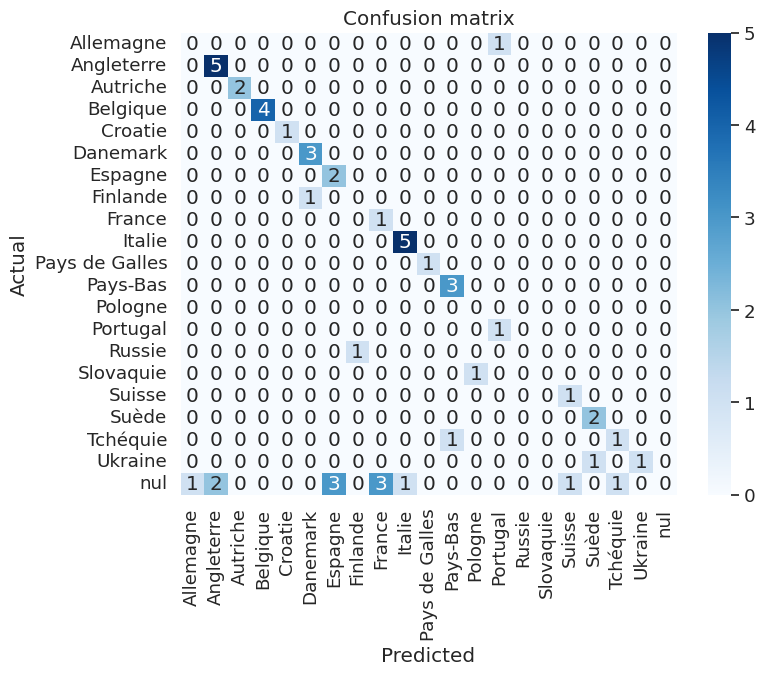

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

actual = best_team
predicted = res_initial

# Créer une matrice de confusion à partir des deux listes
conf_matrix = confusion_matrix(actual, predicted)

# Créer une liste de toutes les classes impliquées
classes = np.unique(actual + predicted)

# Créer une heatmap colorée de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

actual = best_team
predicted = res_initial
# Calculer les métriques d'évaluation
accuracy = accuracy_score(actual, predicted)
precision = precision_score(actual, predicted, average='weighted',zero_division=0)
recall = recall_score(actual, predicted, average='weighted',zero_division=0)
f1 = f1_score(actual, predicted, average='weighted')

# Afficher les métriques
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.6470588235294118
Precision: 0.5219887955182073
Recall: 0.6470588235294118
F1 Score: 0.562049062049062


In [13]:
#mean and median of winner and draw list to adapt the distance to the model 
print(np.mean(res_draw_distance))
print(np.mean(res_winner_distance))
print(np.median(res_draw_distance))
print(np.median(res_winner_distance))

1.35910149531386
1.862810718632946
1.1765430778970325
2.095843859770665


## I take distance inferior to 1.3 by taking mean of draw distance of dataset 2016 and 2020

In [14]:
res_final = []
p=1
for index, row in df_historical1.iterrows():
    home, away = row['HomeTeam'], row['AwayTeam']
    score = predict_points(home, away)
    prob_home, prob_away = score
    distance = minkowski_distance(prob_home, prob_away, p)
    if distance < 1.30:
        res_final.append('nul')
    else:
        index = score.index(max(score))
        res_final.append([home, away][index])

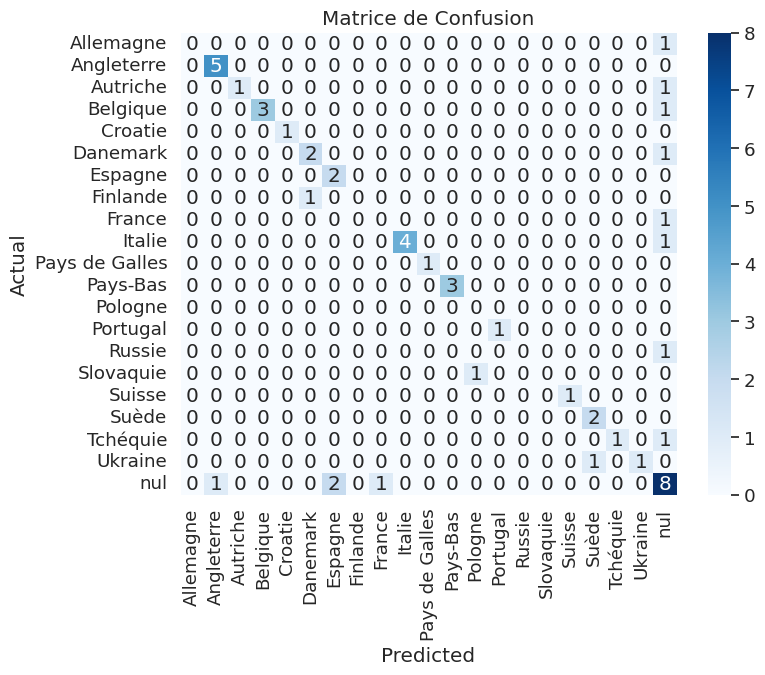

In [15]:
actual = best_team
predicted = res_final

# Créer une matrice de confusion à partir des deux listes
conf_matrix = confusion_matrix(actual, predicted)

# Créer une liste de toutes les classes impliquées
classes = np.unique(actual + predicted)

# Créer une heatmap colorée de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de Confusion')
plt.show()

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

actual = best_team
predicted = res_final
# Calculer les métriques d'évaluation
accuracy = accuracy_score(actual, predicted)
precision = precision_score(actual, predicted, average='weighted',zero_division=0)
recall = recall_score(actual, predicted, average='weighted',zero_division=0)
f1 = f1_score(actual, predicted, average='weighted')

# Afficher les métriques
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7058823529411765
Precision: 0.7156862745098039
Recall: 0.7058823529411765
F1 Score: 0.6903715021362079
